In [1]:
# Cell 1 — Imports & config
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [5]:
# Cell 2 — Load the dataset (use latin1 encoding as file may not be utf-8)
file_path = "C:/Users/preet/Downloads/IMDb Movies India.csv"
df = pd.read_csv(file_path, encoding="latin1")
df.columns = df.columns.str.strip()   # trim whitespace around column names
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [7]:
# Cell 3 — Quick overview: info and missing values
print("Rows:", df.shape[0], "Columns:", df.shape[1])
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(20))


Rows: 15509 Columns: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


None

Duration    8269
Rating      7590
Votes       7589
Actor 3     3144
Actor 2     2384
Genre       1877
Actor 1     1617
Year         528
Director     525
Name           0
dtype: int64

In [9]:
# Cell 4 — Cleaning helper functions & basic cleaning
def extract_year(x):
    if pd.isna(x): 
        return np.nan
    m = re.search(r'(\d{4})', str(x))
    return int(m.group(1)) if m else np.nan

def extract_int(x):
    if pd.isna(x): 
        return np.nan
    m = re.search(r'(\d+)', str(x).replace(',', ''))
    return int(m.group(1)) if m else np.nan

# Work on a copy
df = df.copy()

# Strip whitespace in string columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})

# Year: extract 4-digit year
df['Year'] = df['Year'].apply(extract_year)

# Duration: extract minutes as integer (e.g. "120 min" -> 120)
if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].apply(extract_int)

# Votes: remove commas and convert to numeric
if 'Votes' in df.columns:
    df['Votes'] = df['Votes'].astype(str).str.replace('[^0-9]', '', regex=True)
    df.loc[df['Votes']=='', 'Votes'] = np.nan
    df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

# Rating - ensure float
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Drop exact duplicates (same Name & Year)
df = df.drop_duplicates(subset=['Name','Year']).reset_index(drop=True)

print("After cleaning: shape =", df.shape)
display(df.head())


After cleaning: shape = (15485, 10)


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,2021.0,90.0,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,2010.0,105.0,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [11]:
# Cell 5 — Keep only rows with a rating (target) and create basic lists
df = df.dropna(subset=['Rating']).copy()      # only rows where we have target
print("Rows with ratings:", df.shape[0])

# Genres: split into list
df['Genre'] = df['Genre'].fillna('')
df['genres_list'] = df['Genre'].apply(lambda s: [g.strip() for g in s.split(',') if g.strip()] if s else [])

# Actors: unify actor columns into a list (Actor 1, Actor 2, Actor 3)
actor_cols = [c for c in df.columns if c.lower().startswith('actor')]
# If actor columns have names like 'Actor 1' etc., use them; else adjust above.
df['actors_list'] = df[actor_cols].apply(lambda row: [a for a in row.values if pd.notna(a)], axis=1)
df['num_actors'] = df['actors_list'].apply(len)

# Quick check
display(df[['Name','Year','Duration','Rating','Votes','Director','genres_list','actors_list']].head())


Rows with ratings: 7915


,Name,Year,Duration,Rating,Votes,Director,genres_list,actors_list
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,7.0,8.0,Gaurav Bakshi,[Drama],"[Rasika Dugal, Vivek Ghamande, Arvind Jangid]"
3,#Yaaram,2019.0,110.0,4.4,35.0,Ovais Khan,"[Comedy, Romance]","[Prateik, Ishita Raj, Siddhant Kapoor]"
5,...Aur Pyaar Ho Gaya,1997.0,147.0,4.7,827.0,Rahul Rawail,"[Comedy, Drama, Musical]","[Bobby Deol, Aishwarya Rai Bachchan, Shammi Ka..."
6,...Yahaan,2005.0,142.0,7.4,1086.0,Shoojit Sircar,"[Drama, Romance, War]","[Jimmy Sheirgill, Minissha Lamba, Yashpal Sharma]"
8,?: A Question Mark,2012.0,82.0,5.6,326.0,Allyson Patel,"[Horror, Mystery, Thriller]","[Yash Dave, Muntazir Ahmad, Kiran Bhatia]"


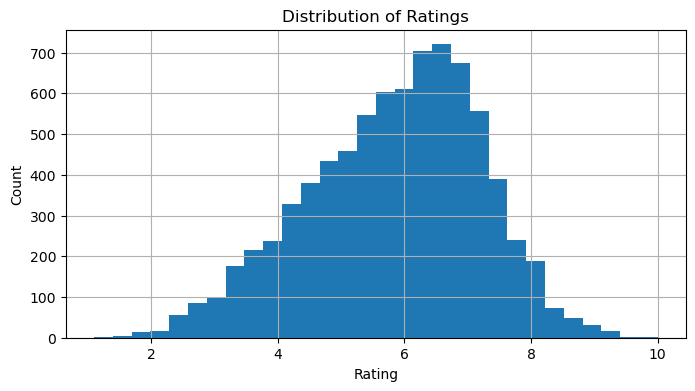

Top 15 genres: ['Drama', 'Action', 'Romance', 'Comedy', 'Crime', 'Thriller', 'Family', 'Musical', 'Adventure', 'Mystery', 'Horror', 'Fantasy', 'Documentary', 'Biography', 'History']

Top 10 directors by count:
 Director
Mahesh Bhatt            47
David Dhawan            43
Hrishikesh Mukherjee    42
Shakti Samanta          39
Kanti Shah              38
Rama Rao Tatineni       34
Basu Chatterjee         34
Ram Gopal Varma         34
Vikram Bhatt            33
Shibu Mitra             33
Name: count, dtype: int64

Top 10 actors:
 [('Mithun Chakraborty', 231), ('Dharmendra', 217), ('Jeetendra', 179), ('Ashok Kumar', 176), ('Amitabh Bachchan', 163), ('Rekha', 133), ('Rajesh Khanna', 132), ('Shashi Kapoor', 126), ('Sanjay Dutt', 123), ('Akshay Kumar', 120)]


In [13]:
# Cell 6 — EDA: Rating distribution & top genres/directors/actors
plt.figure(figsize=(8,4))
plt.hist(df['Rating'], bins=30)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Top genres
genre_counter = Counter([g for lst in df['genres_list'] for g in lst])
top_genres = [g for g, _ in genre_counter.most_common(15)]
print("Top 15 genres:", top_genres)

# Top directors
top_directors = df['Director'].value_counts().head(10)
print("\nTop 10 directors by count:\n", top_directors)

# Top actors
actor_counter = Counter([a for lst in df['actors_list'] for a in lst])
print("\nTop 10 actors:\n", actor_counter.most_common(10))


In [15]:
# Cell 7 — Train/test split (we split before creating target-based encodings)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_train = df_train.copy(); df_test = df_test.copy()

y_train = df_train['Rating'].values
y_test  = df_test['Rating'].values


In [19]:
# Cell 8 — Fixed: Target encoding of Director and Actors using train statistics
import re

# global mean rating from training set
global_mean = df_train['Rating'].mean()

# Director mean-rating (from train only) and map to train/test (fill missing with global mean)
director_mean = df_train.groupby('Director')['Rating'].mean()
df_train['director_mean_rating'] = df_train['Director'].map(director_mean).fillna(global_mean)
df_test['director_mean_rating']  = df_test['Director'].map(director_mean).fillna(global_mean)

# --------------------------
# Identify REAL actor columns (matches "Actor 1", "Actor 2", "Actor3", case-insensitive)
actor_cols = [c for c in df_train.columns if re.match(r'(?i)^\s*actor\s*\d+\s*$', c)]
print("Detected actor columns:", actor_cols)
if not actor_cols:
    raise ValueError("No actor columns detected. Ensure columns are named like 'Actor 1', 'Actor 2', ...")

# Build long form (actor occurrences) from train only, cleaning actor names
actors_long = (
    df_train
    .melt(id_vars=['Rating'], value_vars=actor_cols, value_name='actor')
    .dropna(subset=['actor'])
)
actors_long['actor'] = actors_long['actor'].astype(str).str.strip()

# actor -> mean rating (computed from train)
actor_mean = actors_long.groupby('actor')['Rating'].mean()

# Map actor mean back to each actor column (train & test)
for i, col in enumerate(actor_cols, start=1):
    df_train[f'actor{i}_mean'] = df_train[col].map(actor_mean)
    df_test[f'actor{i}_mean']  = df_test[col].map(actor_mean)

# Combine actor means into summary features
actor_mean_cols = [f'actor{i}_mean' for i in range(1, len(actor_cols)+1)]
df_train['mean_actor_rating'] = df_train[actor_mean_cols].mean(axis=1).fillna(global_mean)
df_test['mean_actor_rating']  = df_test[actor_mean_cols].mean(axis=1).fillna(global_mean)

df_train['num_known_actors'] = df_train[actor_mean_cols].notna().sum(axis=1)
df_test['num_known_actors']  = df_test[actor_mean_cols].notna().sum(axis=1)

# Quick sanity prints
print("Global mean rating:", global_mean)
print("Sample actor_mean mapping (top 10):")
print(actor_mean.sort_values(ascending=False).head(10))


Detected actor columns: ['Actor 1', 'Actor 2', 'Actor 3']
Global mean rating: 5.817956411876185
Sample actor_mean mapping (top 10):
actor
Mahesh Narayan         10.0
Ahaan Jha              10.0
Rajasree Rajakumari    10.0
Purshottam Mulani       9.7
Emon Chatterjee         9.7
Raj Banerjee            9.7
Ashfaq                  9.6
Fasih Choudhry          9.6
Nishi Neha Mishra       9.4
Akash Kumar             9.4
Name: Rating, dtype: float64


In [21]:
# Cell 9 — Genre multi-hot (use top N genres from train)
N_GENRES = 12
genre_counts_train = Counter([g for lst in df_train['genres_list'] for g in lst])
top_genres_train = [g for g,_ in genre_counts_train.most_common(N_GENRES)]
print("Using genres:", top_genres_train)

for g in top_genres_train:
    df_train[f'genre_{g}'] = df_train['genres_list'].apply(lambda lst: 1 if g in lst else 0)
    df_test[f'genre_{g}']  = df_test['genres_list'].apply(lambda lst: 1 if g in lst else 0)

# Fill numeric NaNs (Year, Duration, Votes) with medians from train
for numcol in ['Year','Duration','Votes']:
    median_val = df_train[numcol].median()
    df_train[numcol] = df_train[numcol].fillna(median_val)
    df_test[numcol]  = df_test[numcol].fillna(median_val)


Using genres: ['Drama', 'Action', 'Romance', 'Comedy', 'Crime', 'Thriller', 'Family', 'Musical', 'Adventure', 'Mystery', 'Horror', 'Fantasy']


In [23]:
# Cell 10 — Prepare final feature matrix
feature_cols = ['Year','Duration','Votes','director_mean_rating','mean_actor_rating','num_known_actors'] + [f'genre_{g}' for g in top_genres_train]
print("Feature columns:", feature_cols)

X_train = df_train[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

# Scale numeric features
numeric_cols = ['Year','Duration','Votes','director_mean_rating','mean_actor_rating','num_known_actors']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


Feature columns: ['Year', 'Duration', 'Votes', 'director_mean_rating', 'mean_actor_rating', 'num_known_actors', 'genre_Drama', 'genre_Action', 'genre_Romance', 'genre_Comedy', 'genre_Crime', 'genre_Thriller', 'genre_Family', 'genre_Musical', 'genre_Adventure', 'genre_Mystery', 'genre_Horror', 'genre_Fantasy']


In [25]:
# Cell 11 — Train models (Linear, RandomForest, GradientBoosting) and evaluate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)        # only MSE available in older sklearn
    rmse = np.sqrt(mse)                            # take sqrt to get RMSE
    r2 = r2_score(y_test, preds)

    results.append({'model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f"{name} done: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

results_df = pd.DataFrame(results).sort_values('RMSE')
display(results_df)


LinearRegression done: MAE=0.9245, RMSE=1.1948, R2=0.2109
RandomForest done: MAE=0.9106, RMSE=1.2106, R2=0.1899
GradientBoosting done: MAE=0.9026, RMSE=1.1893, R2=0.2181


,model,MAE,RMSE,R2
2,GradientBoosting,0.902620,1.189319,0.218088
0,LinearRegression,0.924535,1.194788,0.210879
1,RandomForest,0.910641,1.210556,0.189913


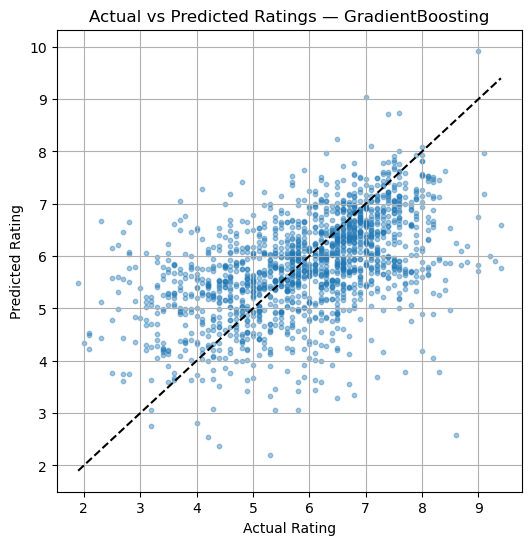

In [35]:
# Cell 12 — Plot predictions vs actuals for the best model (lowest RMSE)
best_model_name = results_df.iloc[0]['model']
best_model = models[best_model_name]
preds_best = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds_best, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title(f"Actual vs Predicted Ratings — {best_model_name}")
plt.grid(True)
plt.show()


,feature,importance
4,mean_actor_rating,0.528674
3,director_mean_rating,0.303175
2,Votes,0.065917
0,Year,0.040899
1,Duration,0.026087
7,genre_Action,0.004805
6,genre_Drama,0.004365
8,genre_Romance,0.004080
10,genre_Crime,0.003499
9,genre_Comedy,0.003494


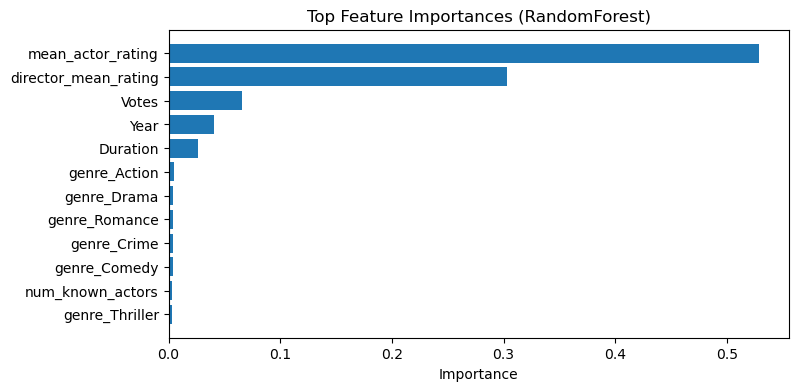

In [37]:
# Cell 13 — Feature importance (RandomForest)
rf = models['RandomForest']
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp.head(20))

# Simple bar plot
plt.figure(figsize=(8,4))
plt.barh(feat_imp['feature'].head(12)[::-1], feat_imp['importance'].head(12)[::-1])
plt.title("Top Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.show()


In [51]:
import joblib
import os

# Define a folder to save models
save_path = "C:/Users/preet/Downloads/movie_rating_models"

# Create folder if it doesn’t exist
os.makedirs(save_path, exist_ok=True)

# Save best model and artifacts
joblib.dump(best_model, os.path.join(save_path, "movie_rating_model_best.pkl"))
joblib.dump(scaler, os.path.join(save_path, "movie_rating_scaler.pkl"))
joblib.dump(top_genres_train, os.path.join(save_path, "movie_top_genres.pkl"))

# Save mappings
joblib.dump(director_mean.to_dict(), os.path.join(save_path, "director_mean_map.pkl"))
joblib.dump(actor_mean.to_dict(), os.path.join(save_path, "actor_mean_map.pkl"))

print(f" Saved model and artifacts under: {save_path}")


 Saved model and artifacts under: C:/Users/preet/Downloads/movie_rating_models


In [53]:
# Cell 15 — Predict function for a single new movie (uses the same preprocessing logic)
import joblib
import numpy as np
import pandas as pd

def preprocess_single(movie_dict, scaler_obj, director_map, actor_map, top_genres):
    # movie_dict keys: Name, Year (int), Duration (int), Genre (str comma separated),
    # Votes (int), Director (str), Actor 1, Actor 2, Actor 3
    d = {}
    # numeric fallback
    d['Year'] = movie_dict.get('Year', np.nan)
    d['Duration'] = movie_dict.get('Duration', np.nan)
    d['Votes'] = movie_dict.get('Votes', np.nan)
    
    # director mean
    d['director_mean_rating'] = director_map.get(movie_dict.get('Director'), np.nan)
    if pd.isna(d['director_mean_rating']):
        d['director_mean_rating'] = global_mean
    
    # actors mean
    actor_means = []
    for i in range(1, len(actor_cols)+1):
        actor_name = movie_dict.get(f'Actor {i}')
        actor_means.append(actor_map.get(actor_name, np.nan))
    actor_means = [v for v in actor_means if not pd.isna(v)]
    d['mean_actor_rating'] = np.mean(actor_means) if actor_means else global_mean
    d['num_known_actors'] = len(actor_means)
    
    # genres
    genres_in = [g.strip() for g in (movie_dict.get('Genre','') or '').split(',') if g.strip()]
    for g in top_genres:
        d[f'genre_{g}'] = 1 if g in genres_in else 0
        
    # Create df
    Xs = pd.DataFrame([d])
    # Fill numeric NaNs with medians from original train
    for numcol in ['Year','Duration','Votes']:
        if pd.isna(Xs.loc[0, numcol]):
            Xs.loc[0, numcol] = df_train[numcol].median()
    # scale numeric features
    Xs[numeric_cols] = scaler_obj.transform(Xs[numeric_cols])
    return Xs[feature_cols]


# --- Load saved objects (local path) ---
save_path = "C:/Users/preet/Downloads/movie_rating_models"

director_map = joblib.load(f"{save_path}/director_mean_map.pkl")
actor_map = joblib.load(f"{save_path}/actor_mean_map.pkl")
scaler_obj = joblib.load(f"{save_path}/movie_rating_scaler.pkl")
top_genres_list = joblib.load(f"{save_path}/movie_top_genres.pkl")
best_loaded = joblib.load(f"{save_path}/movie_rating_model_best.pkl")

# --- Example usage ---
sample_movie = {
    'Name': "Example Movie",
    'Year': 2021,
    'Duration': 120,
    'Genre': "Drama, Romance",
    'Votes': 1200,
    'Director': "Some Director",
    'Actor 1': "Famous Actor",
    'Actor 2': "Supporting Actor",
    'Actor 3': None
}

X_sample = preprocess_single(sample_movie, scaler_obj, director_map, actor_map, top_genres_list)
predicted_rating = best_loaded.predict(X_sample)[0]
print(" Predicted rating:", round(predicted_rating, 2))


 Predicted rating: 6.59


In [27]:
df_train['log_votes'] = np.log1p(df_train['Votes'])
df_test['log_votes'] = np.log1p(df_test['Votes'])


In [29]:
# Define full feature matrix and target
feature_cols = [
    'Year', 'Duration', 'Votes',
    'director_mean_rating', 'mean_actor_rating', 'num_known_actors'
] + [col for col in df_train.columns if col.startswith('genre_')]

X = df_train[feature_cols]
y = df_train['Rating']


In [31]:
from sklearn.model_selection import cross_val_score
import numpy as np

model = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R2 scores across folds:", scores)
print("Mean R2:", np.mean(scores))


R2 scores across folds: [0.77764104 0.77810671 0.78878791 0.76890435 0.78472687]
Mean R2: 0.7796333758641307


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np

# --- Define custom scorers ---
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # neg in sklearn
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# --- Model ---
model = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)

# --- R2 ---
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# --- MAE ---
mae_scores = cross_val_score(model, X, y, cv=5, scoring=mae_scorer)
mae_scores = -mae_scores   # negate back to positive

# --- RMSE ---
mse_scores = cross_val_score(model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(-mse_scores)  # negate and sqrt

# --- Print Results ---
print("R2 scores:", r2_scores, " | Mean:", np.mean(r2_scores))
print("MAE scores:", mae_scores, " | Mean:", np.mean(mae_scores))
print("RMSE scores:", rmse_scores, " | Mean:", np.mean(rmse_scores))


R2 scores: [0.77764104 0.77810671 0.78878791 0.76890435 0.78472687]  | Mean: 0.7796333758641307
MAE scores: [0.46889876 0.47404501 0.46023812 0.48875131 0.46925165]  | Mean: 0.47223696728838027
RMSE scores: [0.6392634  0.66754667 0.63512668 0.66448579 0.65170362]  | Mean: 0.6516252314731962


,feature,importance
4,mean_actor_rating,0.540279
3,director_mean_rating,0.385648
2,Votes,0.042706
0,Year,0.020717
1,Duration,0.003545
5,num_known_actors,0.002450
7,genre_Action,0.000916
13,genre_Musical,0.000863
9,genre_Comedy,0.000704
10,genre_Crime,0.000482


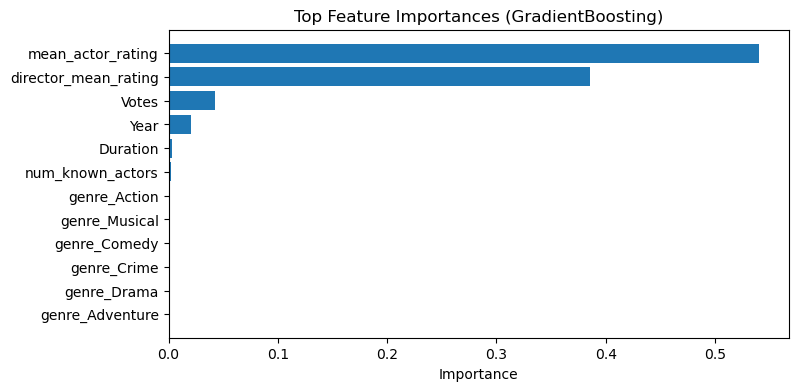

In [45]:
# Cell 13 — Feature importance (GradientBoosting)
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Train Gradient Boosting on full dataset (not CV, just to extract feature importances)
gb_model = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
gb_model.fit(X, y)

# Extract feature importances
importances = gb_model.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importances}).sort_values('importance', ascending=False)

# Display top features
display(feat_imp.head(20))

# Simple bar plot
plt.figure(figsize=(8,4))
plt.barh(feat_imp['feature'].head(12)[::-1], feat_imp['importance'].head(12)[::-1])
plt.title("Top Feature Importances (GradientBoosting)")
plt.xlabel("Importance")
plt.show()


In [49]:
import joblib
import os
from sklearn.ensemble import GradientBoostingRegressor

# Define save path
save_path = "C:/Users/preet/Downloads/movie_rating_models"

# Create folder if not exists
os.makedirs(save_path, exist_ok=True)

# --- Train Gradient Boosting on full dataset ---
gb_model = GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
gb_model.fit(X, y)

# Save Gradient Boosting model and preprocessing artifacts
joblib.dump(gb_model, os.path.join(save_path, "movie_rating_model_gb.pkl"))
joblib.dump(scaler, os.path.join(save_path, "movie_rating_scaler.pkl"))
joblib.dump(top_genres_train, os.path.join(save_path, "movie_top_genres.pkl"))

# Save mappings for directors & actors
joblib.dump(director_mean.to_dict(), os.path.join(save_path, "director_mean_map.pkl"))
joblib.dump(actor_mean.to_dict(), os.path.join(save_path, "actor_mean_map.pkl"))

print(f" Gradient Boosting model and artifacts saved under: {save_path}")


 Gradient Boosting model and artifacts saved under: C:/Users/preet/Downloads/movie_rating_models


In [55]:
# --- Load Gradient Boosting model and saved objects ---
save_path = "C:/Users/preet/Downloads/movie_rating_models"

director_map = joblib.load(f"{save_path}/director_mean_map.pkl")
actor_map = joblib.load(f"{save_path}/actor_mean_map.pkl")
scaler_obj = joblib.load(f"{save_path}/movie_rating_scaler.pkl")
top_genres_list = joblib.load(f"{save_path}/movie_top_genres.pkl")
gb_loaded = joblib.load(f"{save_path}/movie_rating_model_gb.pkl")   # ⬅️ Gradient Boosting

# --- Example movie to predict ---
sample_movie = {
    'Name': "Example Movie",
    'Year': 2021,
    'Duration': 120,
    'Genre': "Drama, Romance",
    'Votes': 1200,
    'Director': "Some Director",
    'Actor 1': "Famous Actor",
    'Actor 2': "Supporting Actor",
    'Actor 3': None
}

# --- Preprocess and predict ---
X_sample = preprocess_single(sample_movie, scaler_obj, director_map, actor_map, top_genres_list)
predicted_rating = gb_loaded.predict(X_sample)[0]

print(" Predicted rating (Gradient Boosting):", round(predicted_rating, 2))


 Predicted rating (Gradient Boosting): 2.45
